In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [4]:
# input: filename prefix and # of files
# output: list of dataframes that are smaller than the original one
# splits a dataframe into dataframes of the desired length (aka chunk_size)
def read_dataframes(filename = "spx_minute_data-", numfiles = 11):     
    chunks = [''] * numfiles
    for i in range(numfiles):
        chunks[i] = pd.read_csv(f"{filename}{i}.csv", index_col=[0])
    chunks = pd.concat(chunks)
    return chunks

In [24]:
def log_mod(x):
    return np.log(abs(x))

In [71]:
spx_price_day = pd.read_csv('data/SPX-Price-Daily.csv')
spx_price_minute = read_dataframes("data/spx_minute_data-")
spx_price_minute = spx_price_minute.drop(['ticker.1', 'trade_date.1'], axis = 1)
spx_gamma = pd.read_csv('data/spx-gamma-dix.csv')

In [72]:
spx_price_minute['volume_scaled'] = pd.Series(spx_price_minute['volume']/1e4).apply(lambda x: log_mod(x))
spx_price_minute['high'] = (spx_price_minute['high_bid_price'] + spx_price_minute['high_ask_price'])/2
spx_price_minute['low'] = (spx_price_minute['low_bid_price'] + spx_price_minute['low_ask_price'])/2
spx_price_minute['liquidity'] = spx_price_minute['volume_scaled']/abs(spx_price_minute['high'] - spx_price_minute['low'])/10

In [73]:
spx_price_minute.head()

,ticker,trade_date,open_bar_time,open_bid_price,open_bid_size,open_ask_price,open_ask_size,first_trade_time,first_trade_price,first_trade_size,...,trade_to_mid_vol_weight,trade_to_mid_vol_weight_relative,time_weight_bid,time_weight_ask,price_adjustment_factor,volume_adjustment_factor,volume_scaled,high,low,liquidity
0,SPY,2011-05-02,2011-05-02T13:30:00+00:00,111.3266,89500.0,111.3347,3600.0,2011-05-02T13:30:00.030000+00:00,111.3347,200.0,...,0.2204,0.2208,111.2535,111.2616,0.8122,1.0,5.108204,111.35505,111.23325,4.193928
1,SPY,2011-05-02,2011-05-02T13:31:00+00:00,111.2535,7800.0,111.2616,133200.0,2011-05-02T13:31:00.024000+00:00,111.2616,100.0,...,0.0641,0.0641,111.2779,111.2860,0.8122,1.0,4.163501,111.30635,111.25755,8.531763
2,SPY,2011-05-02,2011-05-02T13:32:00+00:00,111.2779,64600.0,111.2860,24700.0,2011-05-02T13:32:00.041000+00:00,111.2819,200.0,...,0.1828,0.1783,111.2941,111.3023,0.8122,1.0,4.096421,111.30635,111.27385,12.604372
3,SPY,2011-05-02,2011-05-02T13:33:00+00:00,111.2941,56900.0,111.3023,17300.0,2011-05-02T13:33:00.091000+00:00,111.3023,100.0,...,0.0223,0.0223,111.2779,111.2860,0.8122,1.0,3.668924,111.31445,111.27385,9.036759
4,SPY,2011-05-02,2011-05-02T13:34:00+00:00,111.2779,14600.0,111.2860,62000.0,2011-05-02T13:34:00.240000+00:00,111.2779,100.0,...,0.0888,0.0862,111.2616,111.2698,0.8122,1.0,3.668281,111.29005,111.23730,6.954088


In [74]:
spx_price_minute['liquidity'] = spx_price_minute['liquidity'].replace(np.nan,np.mean(spx_price_minute['liquidity']))
spx_price_minute['liquidity'] = [float(x) for x in spx_price_minute['liquidity']]

In [92]:
spx_price_minute[['time','liquidity']].groupby('time').mean()
spx_price_minute.groupby(['time']).agg(np.sum)#['liquidity'].transform('sum')

,open_bid_price,open_bid_size,open_ask_price,open_ask_size,first_trade_price,first_trade_size,high_bid_price,high_bid_size,high_ask_price,high_ask_size,...,trade_to_mid_vol_weight,trade_to_mid_vol_weight_relative,time_weight_bid,time_weight_ask,price_adjustment_factor,volume_adjustment_factor,volume_scaled,high,low,liquidity
time,,,,,,,,,,,,,,,,,,,,,
13:30:00,393573.8950,21477096.0,393597.9187,25330109.0,393410.7518,2716889.0,393760.2662,2745630.0,393797.8748,43694214.0,...,95.2895,56.2874,393571.0004,393590.4230,1621.9230,1790.0,NaN,393779.07050,393398.69365,NaN
13:31:00,393579.4374,21589403.0,393597.9284,26313091.0,393356.1410,349595.0,393744.9691,3121702.0,393764.7757,44312861.0,...,-21.0049,-18.5311,393593.2007,393611.1015,1621.9230,1790.0,NaN,393754.87240,393440.54065,NaN
13:32:00,393595.3968,24310860.0,393613.6039,26052515.0,393371.0833,321128.0,393745.4227,3612327.0,393764.5534,47226554.0,...,-23.4055,-23.9038,393598.3878,393616.2985,1621.9230,1790.0,NaN,393754.98805,393455.18925,NaN
13:33:00,393601.0173,24252860.0,393618.9948,26671787.0,393207.7060,354469.0,393739.8092,4070541.0,393760.2109,45987534.0,...,-41.7405,-38.0686,393600.5737,393618.0414,1621.9230,1790.0,NaN,393750.01005,393462.71965,NaN
13:34:00,393595.1392,23083160.0,393612.5408,26304202.0,393369.8526,412770.0,393728.6561,3410394.0,393751.0098,49979193.0,...,-63.5351,-60.7482,393588.4924,393605.9058,1621.9230,1790.0,NaN,393739.83295,393456.00725,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20:55:00,216707.9910,27882916.0,216717.3320,26927390.0,215507.9816,179488.0,216785.8623,6444389.0,216796.3450,44440629.0,...,46.4387,26.5179,216710.5057,216719.7804,848.8137,931.0,NaN,216791.10365,216638.76125,NaN
20:56:00,216711.0211,29222867.0,216720.2414,28047367.0,214586.2757,224966.0,216762.8073,8710836.0,216773.1774,48022388.0,...,9.5754,1.3612,216704.5391,216713.7310,848.8137,931.0,NaN,216767.99235,216652.12050,NaN
20:57:00,216704.4981,31347865.0,216713.6299,30866853.0,214731.0874,221225.0,216758.8516,8556687.0,216768.9758,49168232.0,...,7.9116,12.9992,216702.6394,216711.7975,848.8137,931.0,NaN,216763.91370,216651.04740,NaN


In [93]:
spx_price_minute['time'] = pd.to_datetime(spx_price_minute['open_bar_time'])
spx_price_minute['time'] = [str(x.time()) for x in spx_price_minute['time']]

In [94]:
spx_price_minute

,ticker,trade_date,open_bar_time,open_bid_price,open_bid_size,open_ask_price,open_ask_size,first_trade_time,first_trade_price,first_trade_size,...,trade_to_mid_vol_weight_relative,time_weight_bid,time_weight_ask,price_adjustment_factor,volume_adjustment_factor,volume_scaled,high,low,liquidity,time
0,SPY,2011-05-02,2011-05-02T13:30:00+00:00,111.3266,89500.0,111.3347,3600.0,2011-05-02T13:30:00.030000+00:00,111.3347,200.0,...,0.2208,111.2535,111.2616,0.8122,1.0,5.108204,111.35505,111.23325,4.193928,13:30:00
1,SPY,2011-05-02,2011-05-02T13:31:00+00:00,111.2535,7800.0,111.2616,133200.0,2011-05-02T13:31:00.024000+00:00,111.2616,100.0,...,0.0641,111.2779,111.2860,0.8122,1.0,4.163501,111.30635,111.25755,8.531763,13:31:00
2,SPY,2011-05-02,2011-05-02T13:32:00+00:00,111.2779,64600.0,111.2860,24700.0,2011-05-02T13:32:00.041000+00:00,111.2819,200.0,...,0.1783,111.2941,111.3023,0.8122,1.0,4.096421,111.30635,111.27385,12.604372,13:32:00
3,SPY,2011-05-02,2011-05-02T13:33:00+00:00,111.2941,56900.0,111.3023,17300.0,2011-05-02T13:33:00.091000+00:00,111.3023,100.0,...,0.0223,111.2779,111.2860,0.8122,1.0,3.668924,111.31445,111.27385,9.036759,13:33:00
4,SPY,2011-05-02,2011-05-02T13:34:00+00:00,111.2779,14600.0,111.2860,62000.0,2011-05-02T13:34:00.240000+00:00,111.2779,100.0,...,0.0862,111.2616,111.2698,0.8122,1.0,3.668281,111.29005,111.23730,6.954088,13:34:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061185,SPY,2022-02-18,2022-02-18T20:55:00+00:00,434.0400,200.0,434.0500,700.0,2022-02-18T20:55:00.009000+00:00,434.0450,100.0,...,-0.0062,434.1822,434.1950,1.0000,1.0,3.909632,434.43500,433.97500,0.849920,20:55:00
1061186,SPY,2022-02-18,2022-02-18T20:56:00+00:00,434.1300,1100.0,434.1400,700.0,2022-02-18T20:56:00.010000+00:00,434.1400,567.0,...,-0.0172,433.8105,433.8231,1.0000,1.0,4.125045,434.14500,433.68500,0.896749,20:56:00
1061187,SPY,2022-02-18,2022-02-18T20:57:00+00:00,433.8300,1600.0,433.8500,2200.0,2022-02-18T20:57:00.015000+00:00,433.8400,55.0,...,0.0775,433.9238,433.9357,1.0000,1.0,3.960590,434.07500,433.76500,1.277610,20:57:00
1061188,SPY,2022-02-18,2022-02-18T20:58:00+00:00,434.0100,700.0,434.0200,3500.0,2022-02-18T20:58:00.011000+00:00,434.0200,10.0,...,0.4380,434.0958,434.1084,1.0000,1.0,4.343356,434.21500,433.98500,1.888416,20:58:00


In [87]:
mean_minutely_spx = spx_price_minute[['time','liquidity']].infer_objects()
mean_munutely_spx

NameError: name 'mean_munutely_spx' is not defined

In [84]:
type(spx_price_minute['liquidity'].iloc[0]

numpy.float64

In [99]:
spx_price_minute[['time','liquidity']]

,time,liquidity
0,13:30:00,4.193928
1,13:31:00,8.531763
2,13:32:00,12.604372
3,13:33:00,9.036759
4,13:34:00,6.954088
...,...,...
1061185,20:55:00,0.849920
1061186,20:56:00,0.896749
1061187,20:57:00,1.277610
1061188,20:58:00,1.888416


In [119]:
ticks = list(set(spx_price_minute['time'].values))
ticks.sort()

In [120]:
spx_mean_minute_liquidity = pd.DataFrame({"time": [], "liquidity": []})

In [160]:
spx_mean_minute_liquidity

,time,liquidity,sma5,std5,ema5
0,2022-02-21 13:30:00,3.249380,3.249380,NaN,3.249380
1,2022-02-21 13:31:00,3.196242,3.222811,0.037574,3.244066
2,2022-02-21 13:32:00,3.374770,3.273464,0.091668,3.257137
3,2022-02-21 13:33:00,3.423610,3.311000,0.106009,3.273784
4,2022-02-21 13:34:00,3.437615,3.336323,0.107864,3.290167
...,...,...,...,...,...
895,2022-02-21 20:55:00,4.911757,5.732749,0.463566,5.349514
896,2022-02-21 20:56:00,6.262205,5.817718,0.522699,5.440783
897,2022-02-21 20:57:00,6.171932,5.850114,0.542246,5.513898
898,2022-02-21 20:58:00,6.194274,5.893359,0.563216,5.581936


In [140]:
for tick in ticks:
    tick_liquidity = spx_price_minute[spx_price_minute['time']==tick]['liquidity'].values
    tick_liquidity = [value for value in tick_liquidity if (value > -np.inf and value < np.inf)]
    tick_data = pd.DataFrame([[tick, np.mean(tick_liquidity)]], columns=['time', 'liquidity'])
    spx_mean_minute_liquidity= pd.concat([spx_mean_minute_liquidity,tick_data])

In [141]:
spx_mean_minute_liquidity

,time,liquidity
0,13:30:00,3.249380
0,13:31:00,3.196242
0,13:32:00,3.374770
0,13:33:00,3.423610
0,13:34:00,3.437615
...,...,...
0,20:55:00,4.911757
0,20:56:00,6.262205
0,20:57:00,6.171932
0,20:58:00,6.194274


In [155]:
spx_mean_minute_liquidity['sma5'] = spx_mean_minute_liquidity['liquidity'].rolling(5,min_periods=0).mean()
spx_mean_minute_liquidity['std5'] = spx_mean_minute_liquidity['liquidity'].rolling(5,min_periods=0).std()
spx_mean_minute_liquidity['ema5'] = spx_mean_minute_liquidity['liquidity'].ewm(alpha =0.1, adjust = False).mean()

In [156]:
spx_mean_minute_liquidity.reset_index(drop = True,inplace = True)
spx_mean_minute_liquidity['time'] = pd.to_datetime(spx_mean_minute_liquidity['time'])

In [157]:
spx_mean_minute_liquidity['sma5']-spx_mean_minute_liquidity['std5']

0           NaN
1      3.185237
2      3.181796
3      3.204991
4      3.228459
         ...   
895    5.269183
896    5.295019
897    5.307868
898    5.330143
899    4.425784
Length: 900, dtype: float64

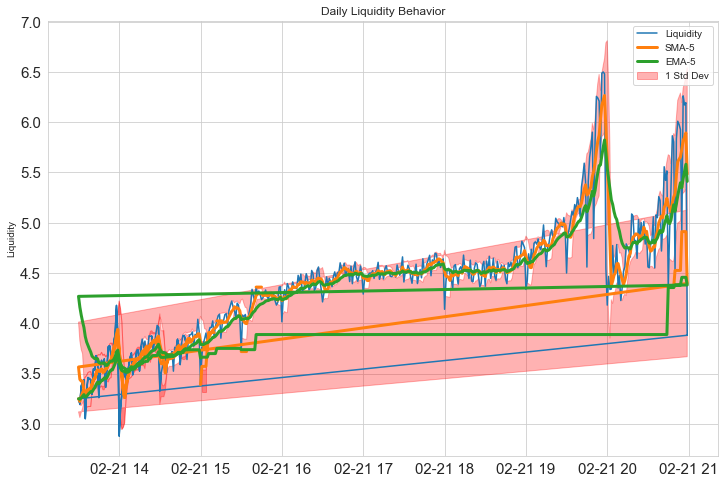

In [159]:
ax = plt.figure(figsize=(12,8))
x = spx_mean_minute_liquidity['time']
plt.plot(x, spx_mean_minute_liquidity['liquidity'])
plt.plot(x, spx_mean_minute_liquidity['sma5'], lw = 3)
plt.plot(x, spx_mean_minute_liquidity['ema5'], lw = 3)
plt.fill_between(x, spx_mean_minute_liquidity['sma5']-abs(spx_mean_minute_liquidity['std5']), spx_mean_minute_liquidity['sma5']+abs(spx_mean_minute_liquidity['std5']), color = 'red', alpha= 0.3)
plt.title('Daily Liquidity Behavior')
plt.ylabel('Liquidity')
plt.legend(['Liquidity','SMA-5','EMA-5','1 Std Dev'])

In [102]:
spx_price_minute[['time','liquidity']].groupby('time',as_index=True).sum()

,liquidity
time,
13:30:00,NaN
13:31:00,NaN
13:32:00,NaN
13:33:00,NaN
13:34:00,NaN
...,...
20:55:00,NaN
20:56:00,NaN
20:57:00,NaN


In [65]:
mean_minutely_spx

,liquidity
time,
13:30:00,NaN
13:31:00,NaN
13:32:00,NaN
13:33:00,NaN
13:34:00,NaN
...,...
20:55:00,NaN
20:56:00,NaN
20:57:00,NaN


In [38]:
mean_minutely_spx

,open_bid_price,open_bid_size,open_ask_price,open_ask_size,first_trade_price,first_trade_size,high_bid_price,high_bid_size,high_ask_price,high_ask_size,...,time_weight_ask,price_adjustment_factor,volume_adjustment_factor,high,low,volume_scaled,liquidity,sma5,std5,ema5
time,,,,,,,,,,,,,,,,,,,,,
13:30:00,219.873684,11998.377654,219.887105,14150.898883,219.905395,1518.663499,219.977802,1533.871508,219.998813,24410.175419,...,219.882918,0.906102,1.0,219.988308,219.775807,NaN,NaN,NaN,NaN,NaN
13:31:00,219.876781,12061.118994,219.887111,14700.050838,219.874869,195.413639,219.969256,1743.967598,219.980322,24755.788268,...,219.894470,0.906102,1.0,219.974789,219.799185,NaN,NaN,NaN,NaN,NaN
13:32:00,219.885697,13581.486034,219.895868,14554.477654,219.883222,179.501397,219.969510,2018.059777,219.980197,26383.549721,...,219.897373,0.906102,1.0,219.974854,219.807368,NaN,NaN,NaN,NaN,NaN
13:33:00,219.888836,13549.083799,219.898880,14900.439665,219.914824,198.248881,219.966374,2274.045251,219.977771,25691.359777,...,219.898347,0.906102,1.0,219.972073,219.811575,NaN,NaN,NaN,NaN,NaN
13:34:00,219.885553,12895.620112,219.895274,14695.084916,219.882534,230.726663,219.960143,1905.248045,219.972631,27921.336872,...,219.891567,0.906102,1.0,219.966387,219.807825,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20:55:00,232.769056,29949.426423,232.779089,28923.082707,233.233746,194.251082,232.852698,6922.007519,232.863958,47734.295381,...,232.781719,0.911723,1.0,232.858328,232.694695,NaN,NaN,NaN,NaN,3.746613
20:56:00,232.772311,31388.686359,232.782214,30126.065521,232.992699,244.262758,232.827935,9356.429646,232.839073,51581.512352,...,232.775221,0.911723,1.0,232.833504,232.709045,NaN,NaN,NaN,NaN,3.746613
20:57:00,232.765304,33671.176155,232.775113,33154.514501,232.897058,239.940347,232.823686,9190.856069,232.834560,52812.279270,...,232.773144,0.911723,1.0,232.829123,232.707892,NaN,NaN,NaN,NaN,3.746613


In [41]:
mean_minutely_spx['liquidity']

time
13:30:00   NaN
13:31:00   NaN
13:32:00   NaN
13:33:00   NaN
13:34:00   NaN
            ..
20:55:00   NaN
20:56:00   NaN
20:57:00   NaN
20:58:00   NaN
20:59:00   NaN
Name: liquidity, Length: 450, dtype: float64